In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from seisfwi.model import ElasticModel, ElasticModelRBF
from seisfwi.survey import Survey, Source, Receiver, GenericCable, SeismicData
from seisfwi.propagator import ElasticPropagator
from seisfwi.problem import ElasticFWI, WaveformL2Loss
from seisfwi.signal import add_noise
from seisfwi.utils import wavelet, smooth2d, load_misfit, plot_misfit, gmsh_center2d, set_sigma, RBF, plot_animation, interp_data2d
from IPython.display import HTML

### Elastic Earth Model

In [3]:
def plot_2d(x, z, d, centers = None):

    if type(d) is list:
        plt.figure(figsize=(15, 6))

        for i, dd in enumerate(d):
            plt.subplot(1, len(d), i+1)
            plt.imshow(dd, extent=[x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000],aspect='equal',cmap='jet')
            plt.grid()
            plt.colorbar(orientation='horizontal')
            plt.xlabel("Distance (km)")
            plt.ylabel("Depth (km)")
        
    else:
        plt.figure(figsize=(6, 6))
        plt.imshow(d, extent=[x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000], aspect='equal',cmap='jet')
        if centers is not None:
            plt.scatter(centers[:,0]/1000, centers[:,1]/1000, marker='.', color = 'r')
        plt.grid()
        plt.colorbar(orientation='horizontal')
        plt.xlabel("Distance (km)")
        plt.ylabel("Depth (km)")
    
    plt.tight_layout()
    plt.show()

def inversion(operator, dobs, niter = 20):

    # observed data
    dobs = torch.tensor(dobs, dtype=torch.float32, device = operator.device)
    
    # optimizer
    optimizer = torch.optim.LBFGS(operator.parameters(), line_search_fn='strong_wolfe')
    
    misfits = []  # List to store the misfit values
    def closure():
        optimizer.zero_grad()
        lam, mu, buoyancy = operator()
        # fit vp
        dsyn = torch.sqrt((lam+2*mu) * buoyancy)
        loss = torch.nn.MSELoss()(dsyn, dobs)
        loss.backward()
        misfits.append(loss.item())  # Record the misfit
    
        return loss
    
    # Run the optimization
    for i in range(niter):
        loss = optimizer.step(closure)
        
        # if i%5 == 0:
        print(f"Iteration: {i + 1}/{niter}, misfit: {loss.item(): .2e}")

    # finial data 
    lam, mu, buoyancy = operator()
    dsyn = torch.sqrt((lam+2*mu) * buoyancy)
    dsyn = dsyn.detach().cpu().numpy()

    return dsyn, np.array(misfits)


In [4]:
nx, nz = 376, 188
dx, dz = 8, 8
ox, oz = 0.0, 0.0

x = np.arange(nx) * dx
z = np.arange(nz) * dz

# Select the part of the model
vp_bl = np.load('../Proposal-part2-Why/model/SEAM-Monitor-Vp-01-3122-1250-4.0m.npy')
vp_ml = np.load('../Proposal-part2-Why/model/SEAM-Monitor-Vp-51-3122-1250-4.0m.npy')
rho   = np.load('../Proposal-part2-Why/model/SEAM-Monitor-Rho-01-3122-1250-4.0m.npy')

vp_bl = interp_data2d(vp_bl, dx=4, dz=4, dh=dx)
vp_ml = interp_data2d(vp_ml, dx=4, dz=4, dh=dx)
rho = interp_data2d(rho, dx=4, dz=4, dh=dx)

x0, z0 = 4800, 2400
nx1 = int(x0/dx)
nx2 = nx1 + nx
nz1 = int(z0/dx)
nz2 = nz1 + nz

vp_bl = vp_bl[nx1:nx2,nz1:nz2].T
vp_ml = vp_ml[nx1:nx2,nz1:nz2].T
rho = rho[nx1:nx2,nz1:nz2].T
vs = np.zeros((nz, nx), dtype=np.float32)
vp_co2 = vp_ml - vp_bl

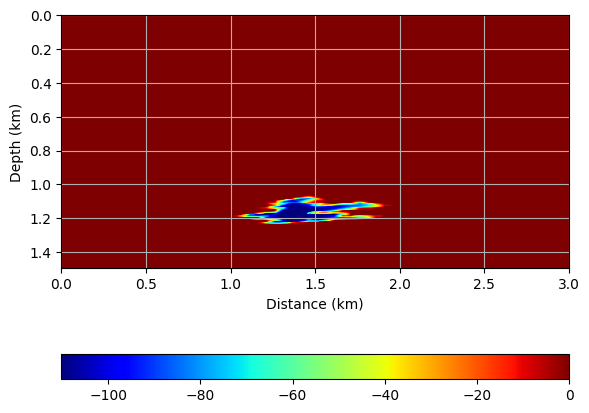

In [5]:
plot_2d(x, z, vp_co2)

In [6]:
density = np.ones((nz, nx), dtype=np.float32)
density[120:170, 90:300] = 2 
density = smooth2d(density, 5, 5)

# Define mesh size bounds
mesh_min = 20
mesh_max = 100

centers_2d, mesh_sizes = gmsh_center2d(density.T, mesh_min, mesh_max, dx)

In [7]:
# centers_2d is in x and z order
print(centers_2d[:,0].max(), centers_2d[:,1].max())

3000.0 1496.0


In [8]:
(nx*nz)/ centers_2d.shape[0]

34.8560157790927

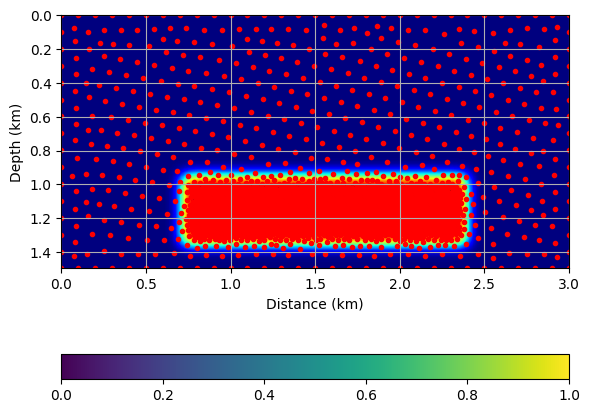

In [9]:
plot_2d(x, z, density, centers_2d)

## Test RBF

In [10]:
sigma = set_sigma(centers_2d, 1.0)
theta_vp = np.zeros(len(centers_2d))
theta_vs = np.zeros(len(centers_2d))
theta_rho = np.zeros(len(centers_2d))

In [11]:
model_op = ElasticModelRBF(ox, oz, dx, dz, nx, nz, centers = centers_2d, 
                           theta_vp = theta_vp, 
                           theta_vs = theta_vs, 
                           theta_rho = theta_rho, 
                           sigma = sigma,
                           update_theta_vp = True, 
                           vp = vp_bl, vs = vs, rho = rho, 
                           device='cuda')

Precomputing the RBF ...


In [12]:
vp_inv, _ = inversion(model_op, vp_ml, niter = 20)

Iteration: 1/20, misfit:  1.12e+02
Iteration: 2/20, misfit:  6.28e+00
Iteration: 3/20, misfit:  5.57e+00
Iteration: 4/20, misfit:  5.15e+00
Iteration: 5/20, misfit:  4.91e+00
Iteration: 6/20, misfit:  4.79e+00
Iteration: 7/20, misfit:  4.70e+00
Iteration: 8/20, misfit:  4.67e+00
Iteration: 9/20, misfit:  4.65e+00
Iteration: 10/20, misfit:  4.64e+00
Iteration: 11/20, misfit:  4.63e+00
Iteration: 12/20, misfit:  4.63e+00
Iteration: 13/20, misfit:  4.63e+00
Iteration: 14/20, misfit:  4.63e+00
Iteration: 15/20, misfit:  4.63e+00
Iteration: 16/20, misfit:  4.63e+00
Iteration: 17/20, misfit:  4.63e+00
Iteration: 18/20, misfit:  4.63e+00
Iteration: 19/20, misfit:  4.63e+00
Iteration: 20/20, misfit:  4.63e+00


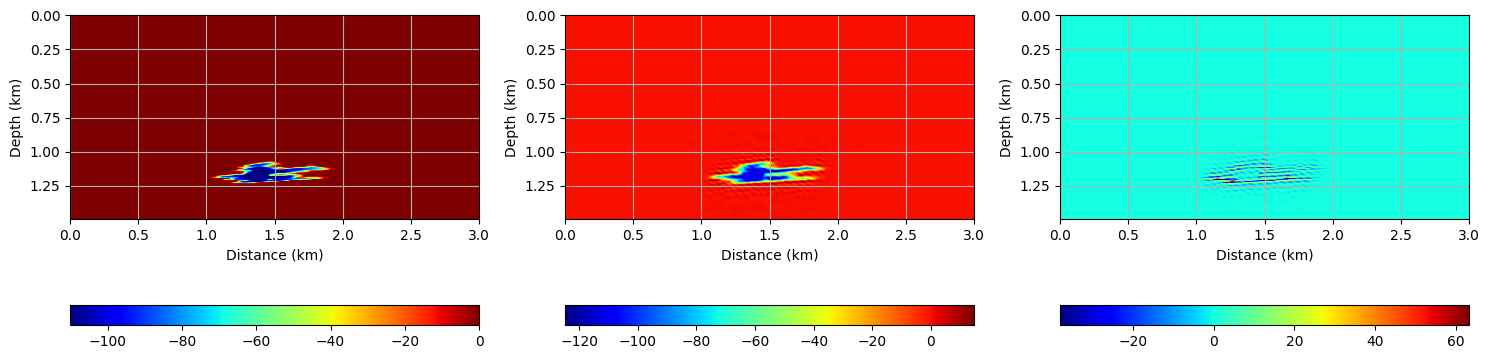

In [13]:
plot_2d(x, z, [vp_ml-vp_bl, vp_inv-vp_bl, vp_ml-vp_inv])

In [14]:
(nx*nz)/centers_2d.shape[0]

34.8560157790927

### From the above test, the center of RBF is legitimate. Move to FWI

In [15]:
nt = 1200
dt = 0.002
f0 = 25
amp = 1e7

vs = np.zeros((nz, nx), dtype=np.float32)
rho = np.ones((nz, nx), dtype=np.float32) * 2000.0

In [16]:
model_bl = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp_bl, vs = vs, rho = rho, free_surface=False, nabc=20)
model_ml = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp_ml, vs = vs, rho = rho, free_surface=False, nabc=20)

model_ml

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1643.23 -  3347.40 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :     0.00 -     0.00 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  2000.00 -  2000.00 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   8.00, dz =   8.00 m
  Model dims: nx =    376, nz =    188
  Model size: 212064
  Free surface: False
  Absorbing layers: 20

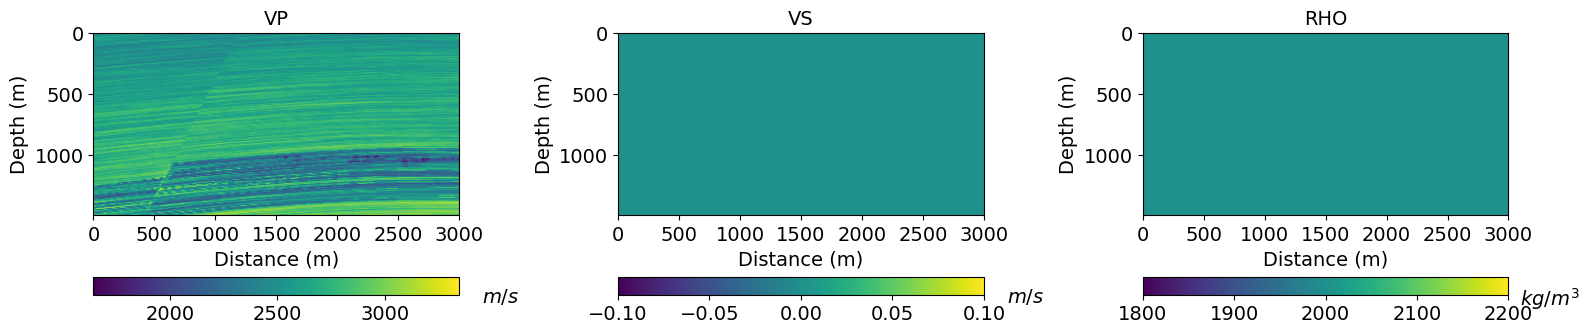

In [17]:
model_bl.plot(orientation='horizontal', cmap = 'viridis')

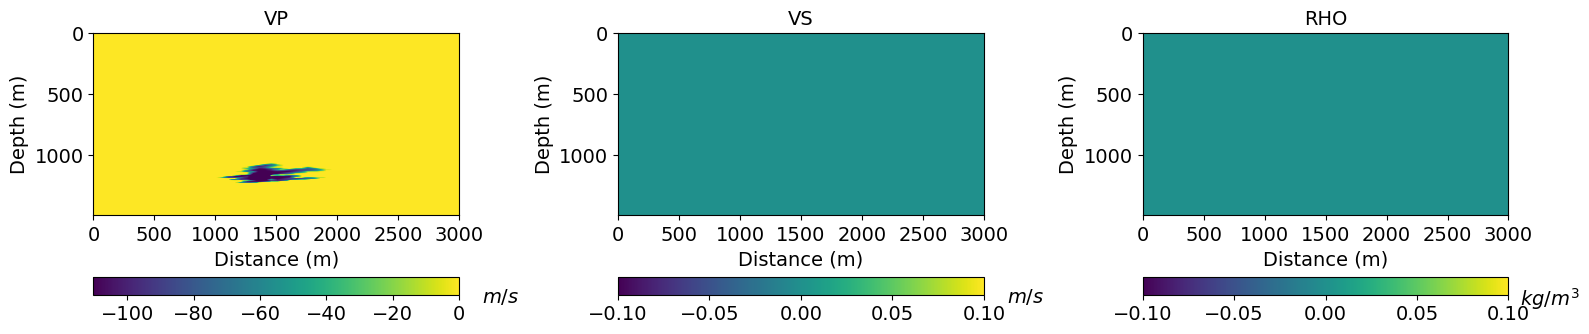

In [18]:
(model_ml - model_bl).plot(orientation='horizontal', cmap = 'viridis')

### Seismic Source 

In [19]:
# Create a seismic sources
source = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

for i in range(12):
    source.add_source([120 + i*240, dx], wvlt, 'pr')

### Receiver

In [20]:
# Create a set of seismic receiver
geophone = Receiver(nt = nt, dt = dt)

for irec in range(nx-2):
    geophone.add_receiver([dx * (irec + 1), dx], 'vx')
    geophone.add_receiver([dx * (irec + 1), dx], 'vz')
    
geophone

Seismic Receiver:
  Receiver data   : 1200 samples at 2.00 ms
  Receiver number : 748
  Receiver types  : ['vz', 'vx']
  Receiver x range:   8.00 - 2992.00 m
  Receiver z range:   8.00 -   8.00 m

### Survey

In [21]:
survey = Survey(source=source, receiver=geophone, device='cuda', gpu_num=4)

survey

Survey Information:
  Device   : cuda
  GPU num  : 4
  Apply reciprocity: False
  Simultaneous source: False
  Apply interpolation: False

Seismic Source:
  Source wavelet: 1200 samples at 2.00 ms
  Source number : 12
  Source types  : ['pr']
  Source x range: 120.00 - 2760.00 m
  Source z range:   8.00 -   8.00 m

Seismic Receiver:
  Receiver data   : 1200 samples at 2.00 ms
  Receiver number : 748
  Receiver types  : ['vz', 'vx']
  Receiver x range:   8.00 - 2992.00 m
  Receiver z range:   8.00 -   8.00 m


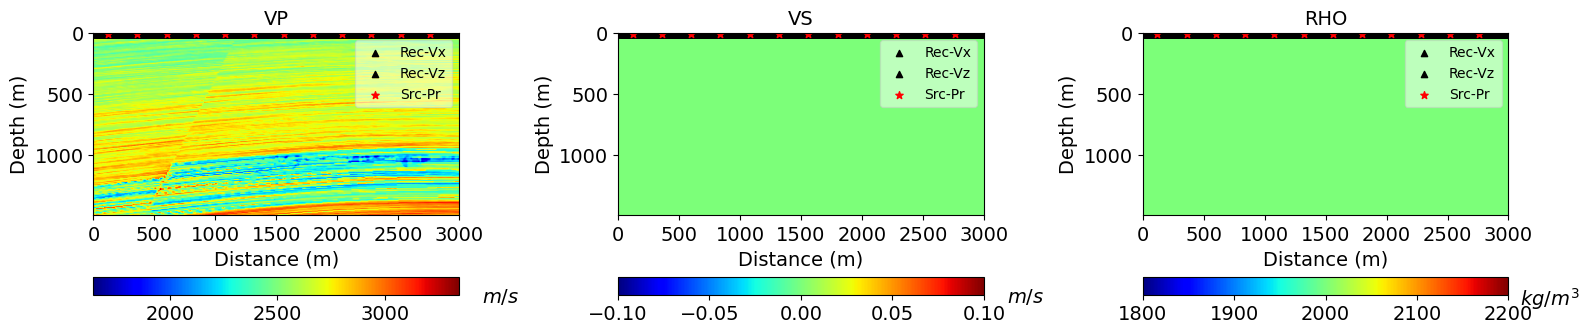

In [22]:
model_bl.plot(survey=survey, orientation='horizontal')

### Elastic Propagator

In [23]:
F = ElasticPropagator(model_bl, survey)

Survey analysis completed: legal survey
free surface: False


### Model the observed data

In [24]:
dobs_bl = F(model_bl)
dobs_ml = F(model_ml)

/sep/haipeng/miniconda3/envs/pytorch/lib/python3.9/site-packages/deepwave/common.py:399: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 25, a minimum velocity of 0.0, and a grid cell spacing of 8.0, there are only 0.0.
  warnings.warn("At least six grid cells per wavelength is "


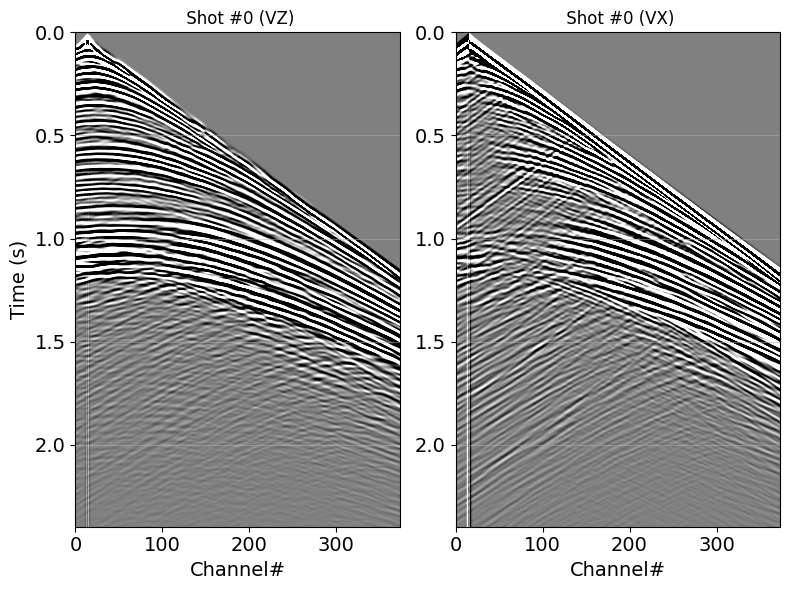

In [25]:
dobs_bl.plot(clip=90, comp={'vx', 'vz'})

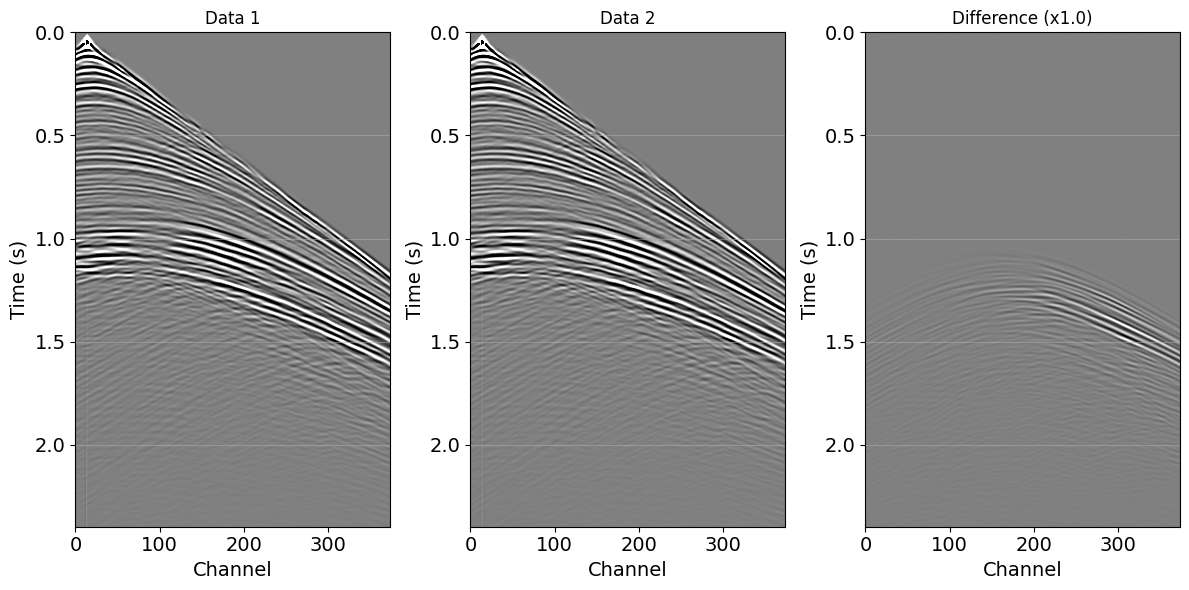

In [26]:
dobs_ml.plot_compare(dobs_bl, clip=98)

## Baseline FWI

In [27]:
grad_mask = np.ones((nz, nx))
grad_mask[:5,:] = 0.0

# grad_mask[10:20, :] = np.repeat(np.linspace(0, 1, 10), nx).reshape(10, nx)
grad_mask = smooth2d(grad_mask, 3, 3)

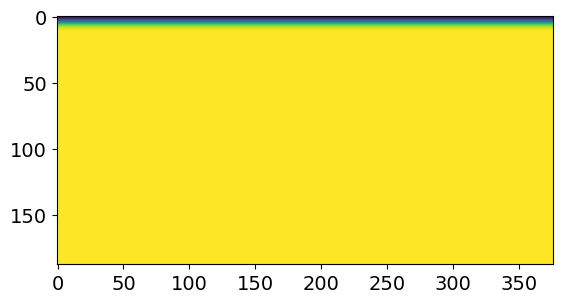

In [28]:
plt.imshow(grad_mask)

In [29]:
vp_init = smooth2d(vp_bl, 5, 5)
# vp_init = vp_bl.copy()

In [30]:
model_init = ElasticModel(ox, oz, dx, dz, nx, nz, 
                                  vp = vp_init, 
                                  vs = vs, 
                                  rho = rho, 
                                  vp_bound = [1400, 5000],
                                  vp_grad=True,
                                  free_surface=False, nabc=20,
                                  mask = grad_mask)

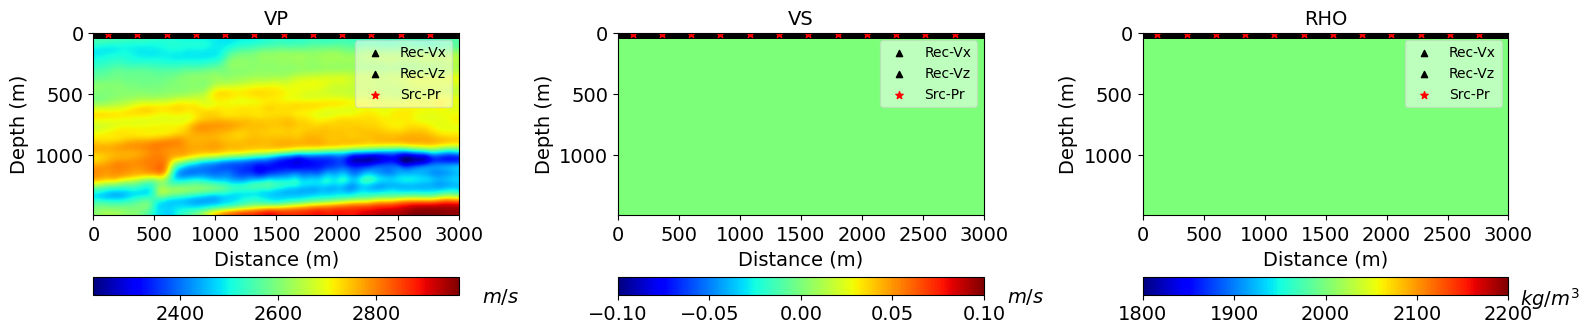

In [31]:
model_init.plot(survey, orientation='horizontal')

In [32]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_init.parameters(), 
              lr = 1.0,
              max_iter = 100,
              tolerance_change = 1e-4, 
              history_size = 5,
              line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vx': 1.0, 'vz': 1.0}

In [33]:
fwi = ElasticFWI(F, model_init, optimizer, misfit, dobs_bl, weight)

In [34]:
fwi(nshot_per_gpu_per_batch = 5, max_iter = 3, grad_scale = 20.0, grad_interval = 4, log_file = 'fwi-acoustic-baseline-SEAM.log')

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :        100
***********************************************************

   Niter           fk                ngrad          max grad
     1       3.214923e+04                1         1.00e+00
     1       3.214912e+04                1         1.00e+00
     1       3.214905e+04                1         1.00e+00
     1       3.214905e+04                1         1.00e+00
     1       3.214905e+04                1         1.00e+00
     1       3.214905e+04                1         1.00e+00
     2       1.973992e+04                7         7.01e-01
     3       1.779492e+04                8         6.26e-01
     4       1.583488e+04                9         3.08e-01
     5       1.499647e+04               10         1.75e-01
     6       1.422199e+0

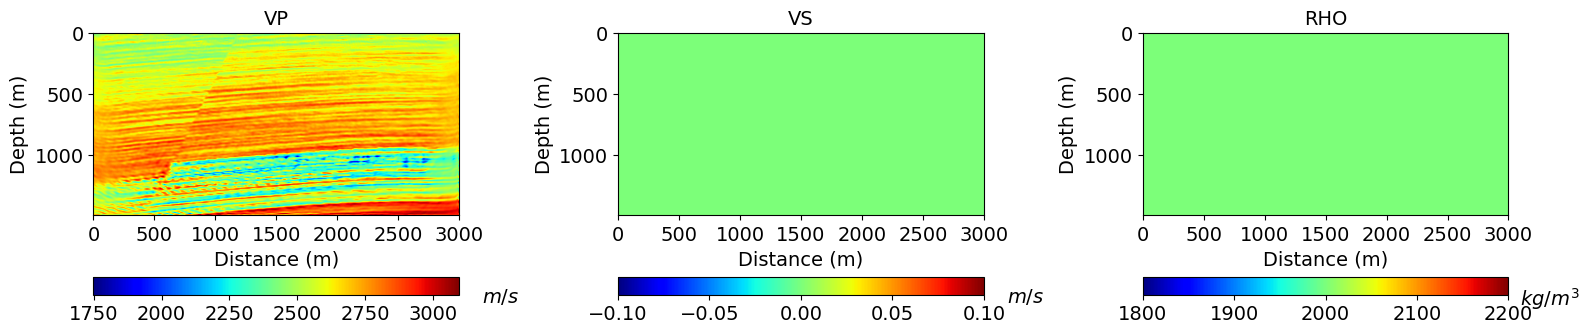

In [35]:
model_init.plot(orientation='horizontal')

In [36]:
# Create a seismic sources
source = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

for i in range(3):
    source.add_source([500 + i*1000, 4 * dx], wvlt, 'pr')

# Create a set of seismic receiver
geophone = Receiver(nt = nt, dt = dt)
for irec in range(29):
    geophone.add_receiver([100 * (irec) + 50, 4 * dx], 'vx')
    geophone.add_receiver([100 * (irec) + 50, 4 * dx], 'vz')

survey_monitor = Survey(source=source, receiver=geophone, device='cuda', gpu_num=4)


In [37]:
F = ElasticPropagator(model_bl, survey_monitor)

Survey analysis completed: legal survey
free surface: False


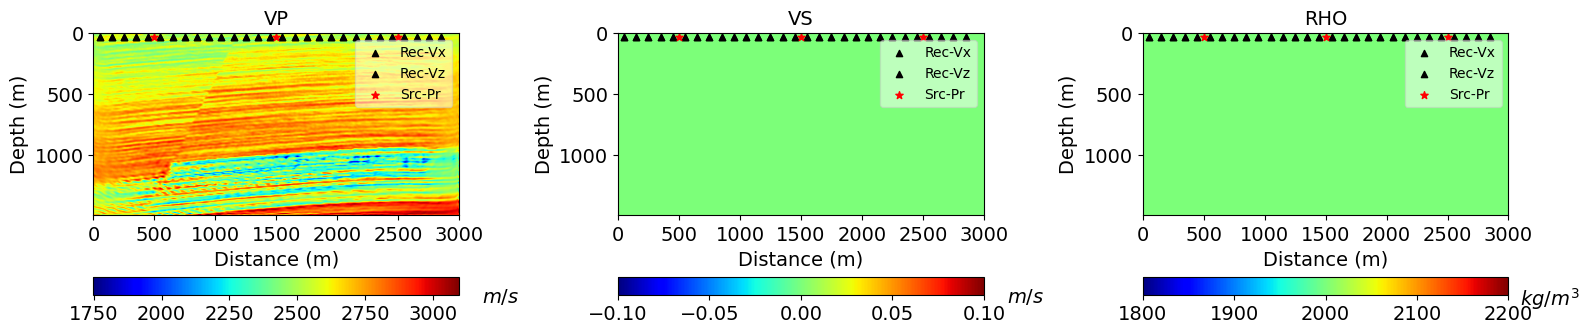

In [38]:
model_init.plot(survey_monitor, orientation='horizontal')

In [39]:
dobs_bl = F(model_bl)
dobs_ml = F(model_ml)

# dobs_bl.data['vx'] = add_noise(dobs_bl.data['vx'], 10, seed=111)
# dobs_bl.data['vz'] = add_noise(dobs_bl.data['vz'], 10, seed=222)

# dobs_ml.data['vx'] = add_noise(dobs_ml.data['vx'], 12, seed=1)
# dobs_ml.data['vz'] = add_noise(dobs_ml.data['vz'], 12, seed=2)

In [40]:
model_fwi_bl = ElasticModel(ox, oz, dx, dz, nx, nz, vp = model_init.get_model('vp'), vs = model_init.get_model('vs'), rho = model_init.get_model('rho'), free_surface=False, nabc=20)

# model the syn data of the baseline model
dsyn_bl = F(model_fwi_bl)

dobs_ml.data['vx'] = dobs_ml.data['vx'] - dobs_bl.data['vx'] + dsyn_bl.data['vx']
dobs_ml.data['vz'] = dobs_ml.data['vz'] - dobs_bl.data['vz'] + dsyn_bl.data['vz']

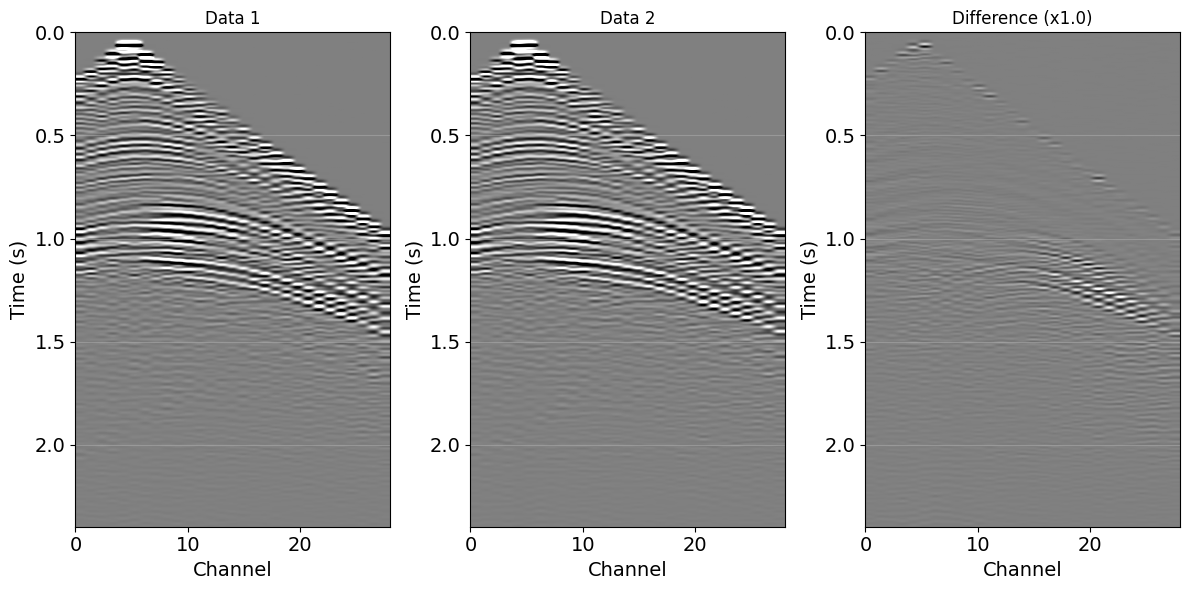

In [41]:
dobs_ml.plot_compare(dobs_bl, clip=98)

### Set initial model

In [42]:
vp_bl_fwi = model_init.get_model('vp')

## FWI with Conventional Parameterization with FD Grid

In [43]:
model_init_fd = ElasticModel(ox, oz, dx, dz, nx, nz, 
                                  vp = vp_bl_fwi, 
                                  vs = vs, 
                                  rho = rho, 
                                  vp_bound = [1400, 5000],
                                  vp_grad=True,
                                  free_surface=False, nabc=20,
                                  mask = grad_mask)

In [44]:
model_init_fd

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1748.41 -  3097.01 m/s   , requires_grad = True, constrain bound: 1400 - 5000
  Model vs  :     0.00 -     0.00 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  2000.00 -  2000.00 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   8.00, dz =   8.00 m
  Model dims: nx =    376, nz =    188
  Model size: 212064
  Free surface: False
  Absorbing layers: 20

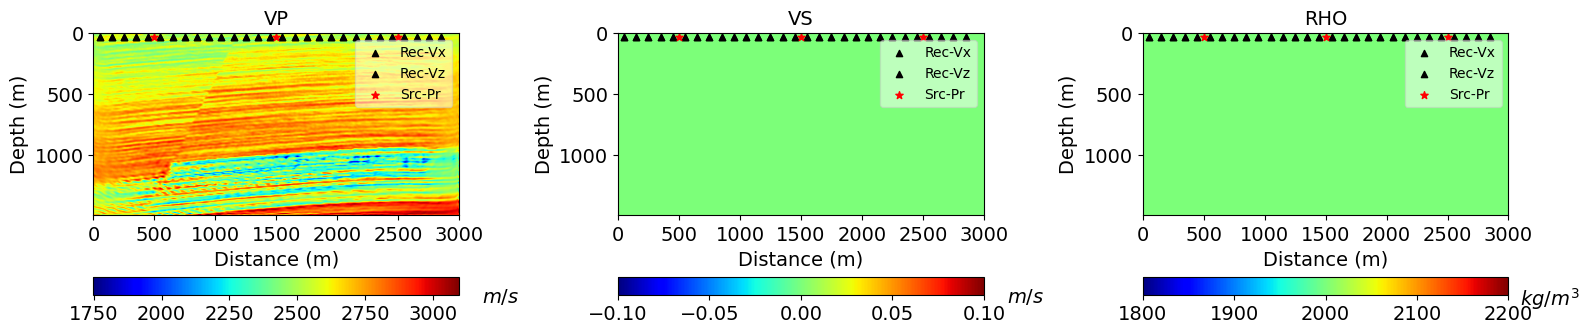

In [45]:
model_init_fd.plot(survey_monitor, orientation='horizontal')

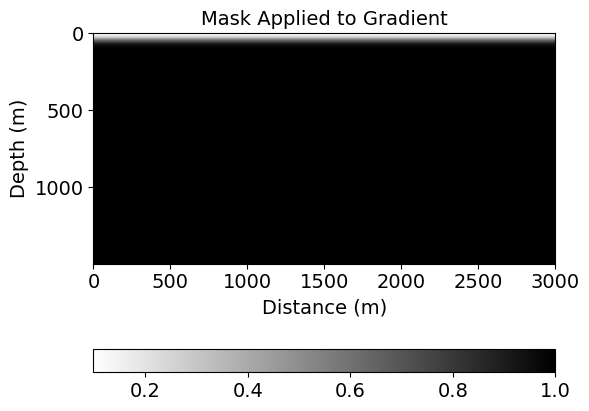

In [46]:
model_init_fd.plot_mask()

### Set optimizer and misfit functional for inversion

In [47]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_init_fd.parameters(), 
              lr = 1.0,
              max_iter = 150,
              tolerance_change = 1e-4, 
              history_size = 5,
              line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vx': 1.0, 'vz': 1.0}
# weight = {'pr': 1.0}

In [48]:
fwi = ElasticFWI(F, model_init_fd, optimizer, misfit, dobs_ml, weight)

In [49]:
fwi(nshot_per_gpu_per_batch = 5, max_iter = 3, grad_scale = 20.0, grad_interval = 4, log_file = 'fwi-acoustic-fd-SEAM.log', cache_result=True)

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :        150
***********************************************************

   Niter           fk                ngrad          max grad
     1       2.005418e+04                1         1.00e+00
     1       2.005424e+04                1         1.00e+00
     1       2.005401e+04                1         1.00e+00
     1       2.005401e+04                1         1.00e+00
     1       2.005401e+04                1         1.00e+00
     1       2.005401e+04                1         1.00e+00
     2       6.815017e+05                7         5.74e+01
     2       1.442641e+04                7         6.28e+00
     3       1.625608e+04                9         3.22e+00
     3       1.127406e+04                9         3.09e+00
     4       1.025227e+0

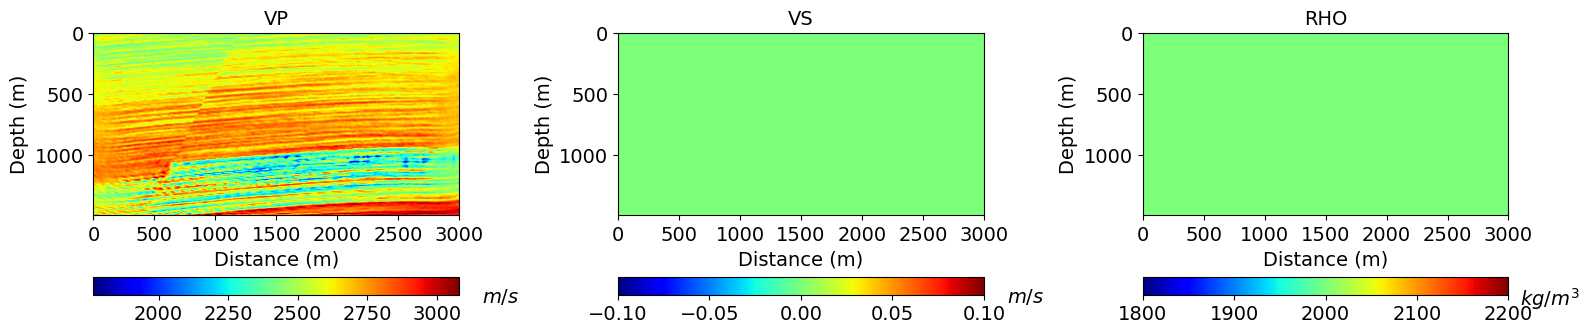

In [50]:
model_init_fd.plot(orientation='horizontal')

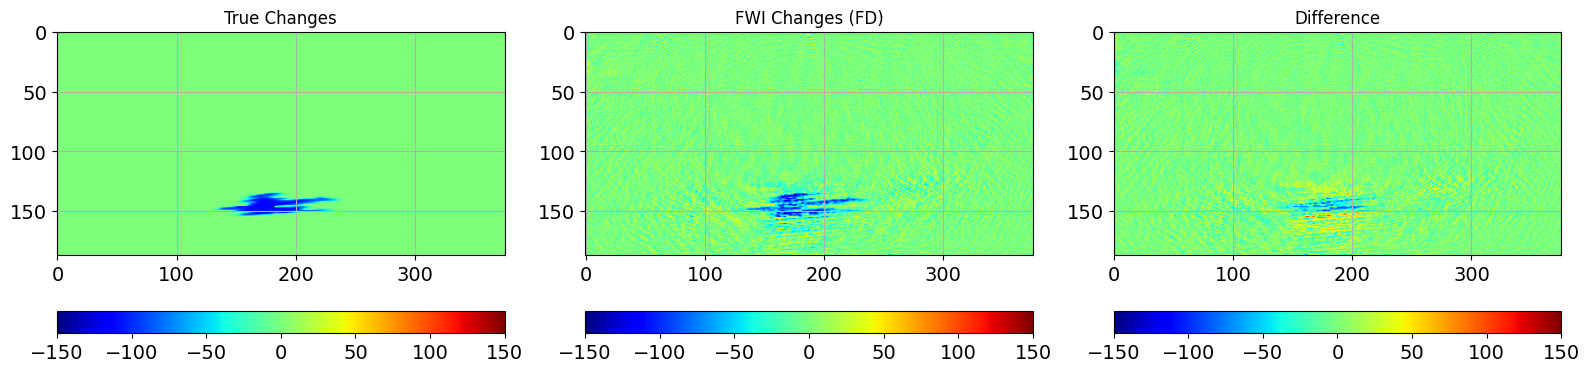

In [51]:
# Plotting
fig = plt.figure(figsize=(16, 4))

shapes = (nx,nz)

plt.subplot(1, 3, 1)
plt.imshow(vp_ml - vp_bl, vmin=-150, vmax=150, cmap='jet')
plt.grid()
plt.title("True Changes")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 3, 2)
plt.imshow(model_init_fd.get_model('vp') - vp_bl_fwi , vmin=-150, vmax=+150, cmap='jet')
plt.grid()
plt.title("FWI Changes (FD)")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 3, 3)
plt.imshow(vp_ml - vp_bl - (model_init_fd.get_model('vp') - vp_bl_fwi), vmin=-150, vmax=+150, cmap='jet')
plt.grid()
plt.title("Difference")
plt.colorbar(orientation='horizontal')

plt.tight_layout()
plt.show()


In [52]:
# vp_chached = fwi.vp_chached
# vp_chached = np.array(vp_chached) - vp_bl_fwi

In [53]:
# vp_plot = plot_animation(vp_chached, vmin=-100, vmax=100, cmap='jet', aspect='auto', width=10, height=6)
# HTML(vp_plot.to_jshtml())

## FWI with RBF Parameterization

In [54]:
# dobs_bl = F(model_bl)
# dobs_ml = F(model_ml)

# model_fwi_bl = ElasticModel(ox, oz, dx, dz, nx, nz, vp = model_init.get_model('vp'), vs = model_init.get_model('vs'), rho = model_init.get_model('rho'), free_surface=False, nabc=20)

# # model the syn data of the baseline model
# dsyn_bl = F(model_fwi_bl)

# dobs_ml.data['vx'] = dobs_ml.data['vx'] - dobs_bl.data['vx'] + dsyn_bl.data['vx']
# dobs_ml.data['vz'] = dobs_ml.data['vz'] - dobs_bl.data['vz'] + dsyn_bl.data['vz']

In [55]:
vp_bl_fwi = model_init.get_model('vp')

3000.0 1496.0


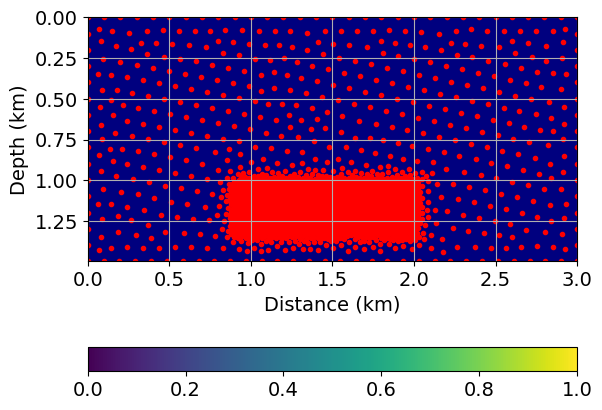

In [56]:
density = np.ones((nz, nx), dtype=np.float32)
density[118:175, 105:260] = 2 
density = smooth2d(density, 5, 5)
# Define mesh size bounds
mesh_min = 16
mesh_max = 100

centers_2d, mesh_sizes = gmsh_center2d(density.T, mesh_min, mesh_max, dx)

# centers_2d is in x and z order
print(centers_2d[:,0].max(), centers_2d[:,1].max())

plot_2d(x, z, density*0, centers_2d)

In [57]:
(nx*nz)/centers_2d.shape[0]

29.06578947368421

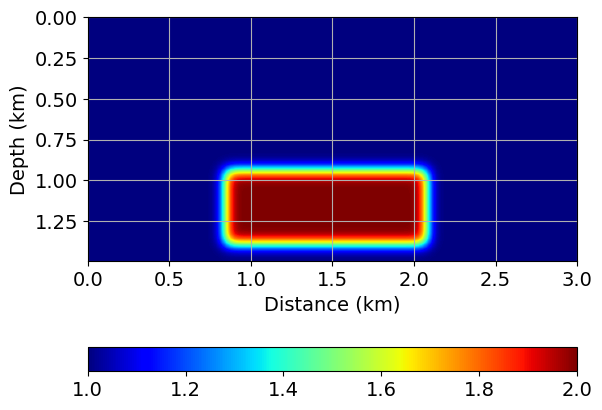

In [58]:
plot_2d(x, z, density)

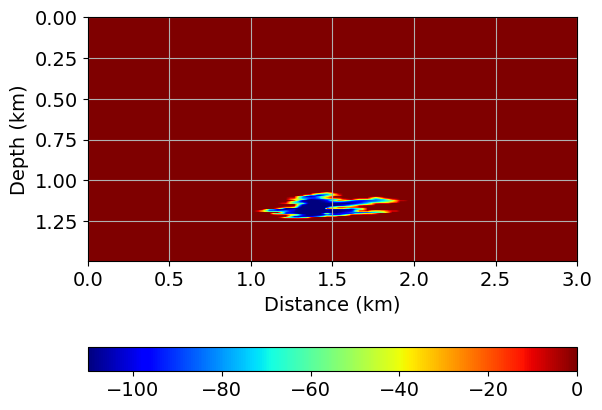

In [59]:
plot_2d(x, z, vp_ml - vp_bl)

In [60]:
sigma = set_sigma(centers_2d, 0.6) # 0.8
theta_vp = np.zeros(len(centers_2d))
theta_vs = np.zeros(len(centers_2d))
theta_rho = np.zeros(len(centers_2d))

In [61]:
model_init_rbf = ElasticModelRBF(ox, oz, dx, dz, nx, nz, 
                                 centers_2d, 
                                 sigma,
                                 theta_vp = theta_vp, 
                                 theta_vs = theta_vs, 
                                 theta_rho = theta_rho, 
                                 update_theta_vp = True, 
                                 vp = vp_bl_fwi, 
                                 vs = vs, 
                                 rho = rho,
                                 vp_bound = [1400, 5000],
                                 free_surface=False, nabc=20,
                                 device='cuda')

Precomputing the RBF ...


In [62]:
model_init_rbf

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1748.41 -  3097.01 m/s   , requires_grad = False, constrain bound: 1400 - 5000
  Model vs  :     0.00 -     0.00 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  2000.00 -  2000.00 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =   8.00, dz =   8.00 m
  Model dims: nx =    376, nz =    188
  Model size: 212064
  Free surface: False
  Absorbing layers: 20

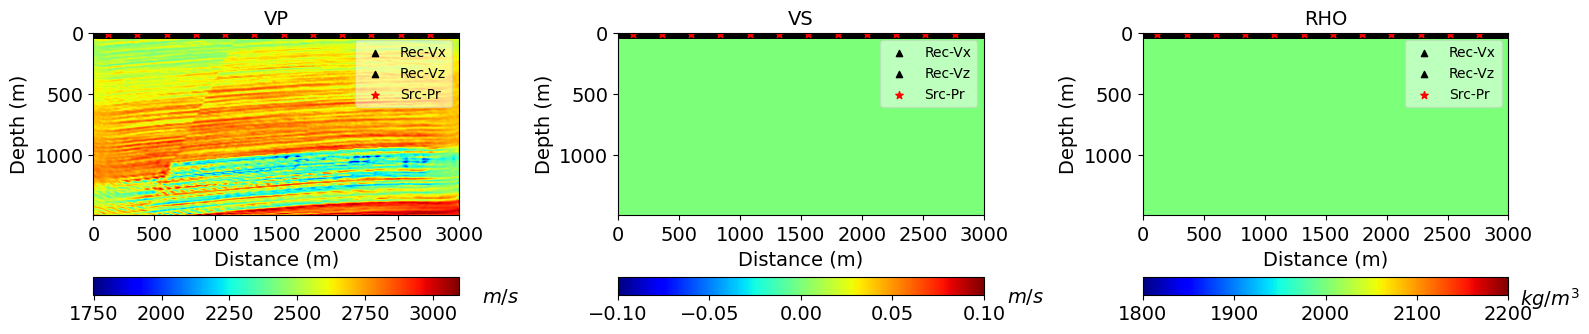

In [63]:
model_init_rbf.plot(survey, orientation='horizontal')

In [64]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_init_rbf.parameters(), 
              lr = 1.0,
              max_iter = 100,
              tolerance_change = 1e-4, 
              history_size = 5,
              line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vx': 1.0, 'vz': 1.0}
# weight = {'pr': 1.0}

In [65]:
fwi = ElasticFWI(F, model_init_rbf, optimizer, misfit, dobs_ml, weight)

In [66]:
fwi(nshot_per_gpu_per_batch = 5, max_iter = 3, grad_scale = 20.0, grad_interval = 4, log_file = 'fwi-acoustic-rbf-SEAM.log', cache_result=True)

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :        100
***********************************************************

   Niter           fk                ngrad          max grad
     1       4.553542e+02                1         9.89e-01
     1       4.545671e+02                1         9.57e-01
     1       4.521319e+02                1         8.57e-01
     1       4.416177e+02                1         7.55e-01
     2       3.834887e+02                5         3.58e-01
     3       3.675250e+02                6         1.13e+00
     4       3.558675e+02                7         6.04e-01
     5       3.375230e+02                8         3.39e-01
     6       3.257783e+02                9         7.57e-01
     7       3.537816e+02               10         4.74e-01
     7       3.210192e+0

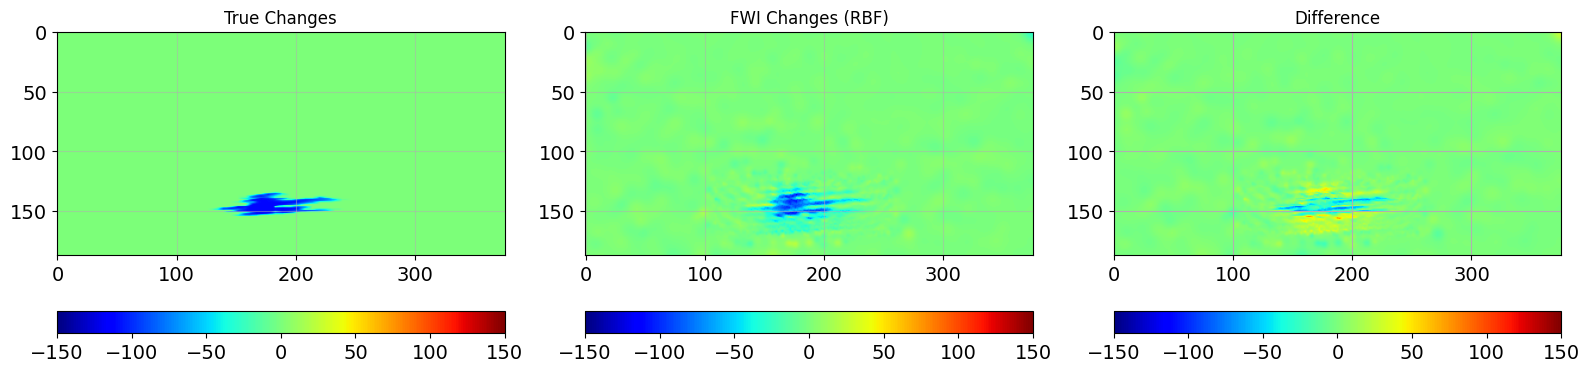

In [67]:
# Plotting
fig = plt.figure(figsize=(16, 4))

shapes = (nx,nz)
plt.subplot(1, 3, 1)
plt.imshow(vp_ml - vp_bl, vmin=-150, vmax=150, cmap='jet')
plt.grid(alpha=0.5)
plt.title("True Changes")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 3, 2)
plt.imshow(model_init_rbf.get_model('vp') - vp_bl_fwi , vmin=-150, vmax=+150, cmap='jet')
plt.grid(alpha=0.5)
plt.title("FWI Changes (RBF)")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 3, 3)
plt.imshow(vp_ml - vp_bl - (model_init_rbf.get_model('vp') - vp_bl_fwi), vmin=-150, vmax=+150, cmap='jet')
plt.grid()
plt.title("Difference")
plt.colorbar(orientation='horizontal')

plt.tight_layout()
plt.show()

In [68]:
# vp_chached = fwi.vp_chached
# vp_chached = np.array(vp_chached) - vp_bl_fwi

In [69]:
# vp_plot = plot_animation(vp_chached, vmin=-100, vmax=100, cmap='jet', aspect='auto', width=10, height=6)
# HTML(vp_plot.to_jshtml())

## Compare results

In [70]:
loss_fd  = load_misfit('fwi-acoustic-fd-SEAM.log')
loss_rbf = load_misfit('fwi-acoustic-rbf-SEAM.log')

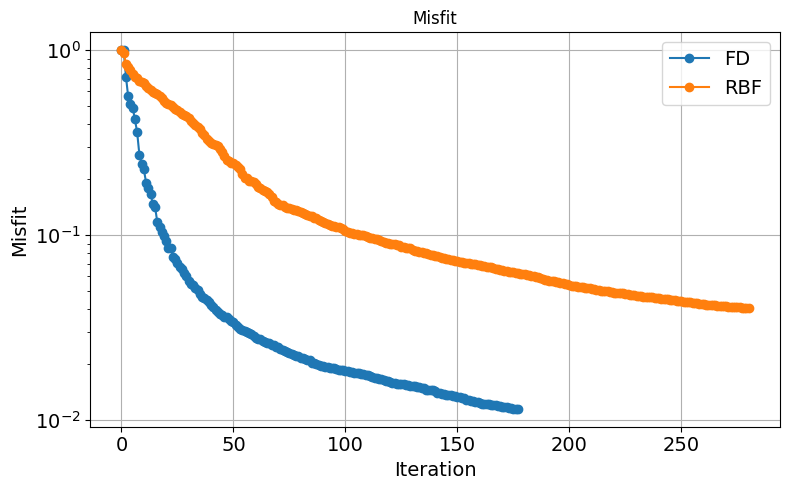

In [71]:
plot_misfit([loss_fd, loss_rbf], label=['FD', 'RBF'])

# Plot

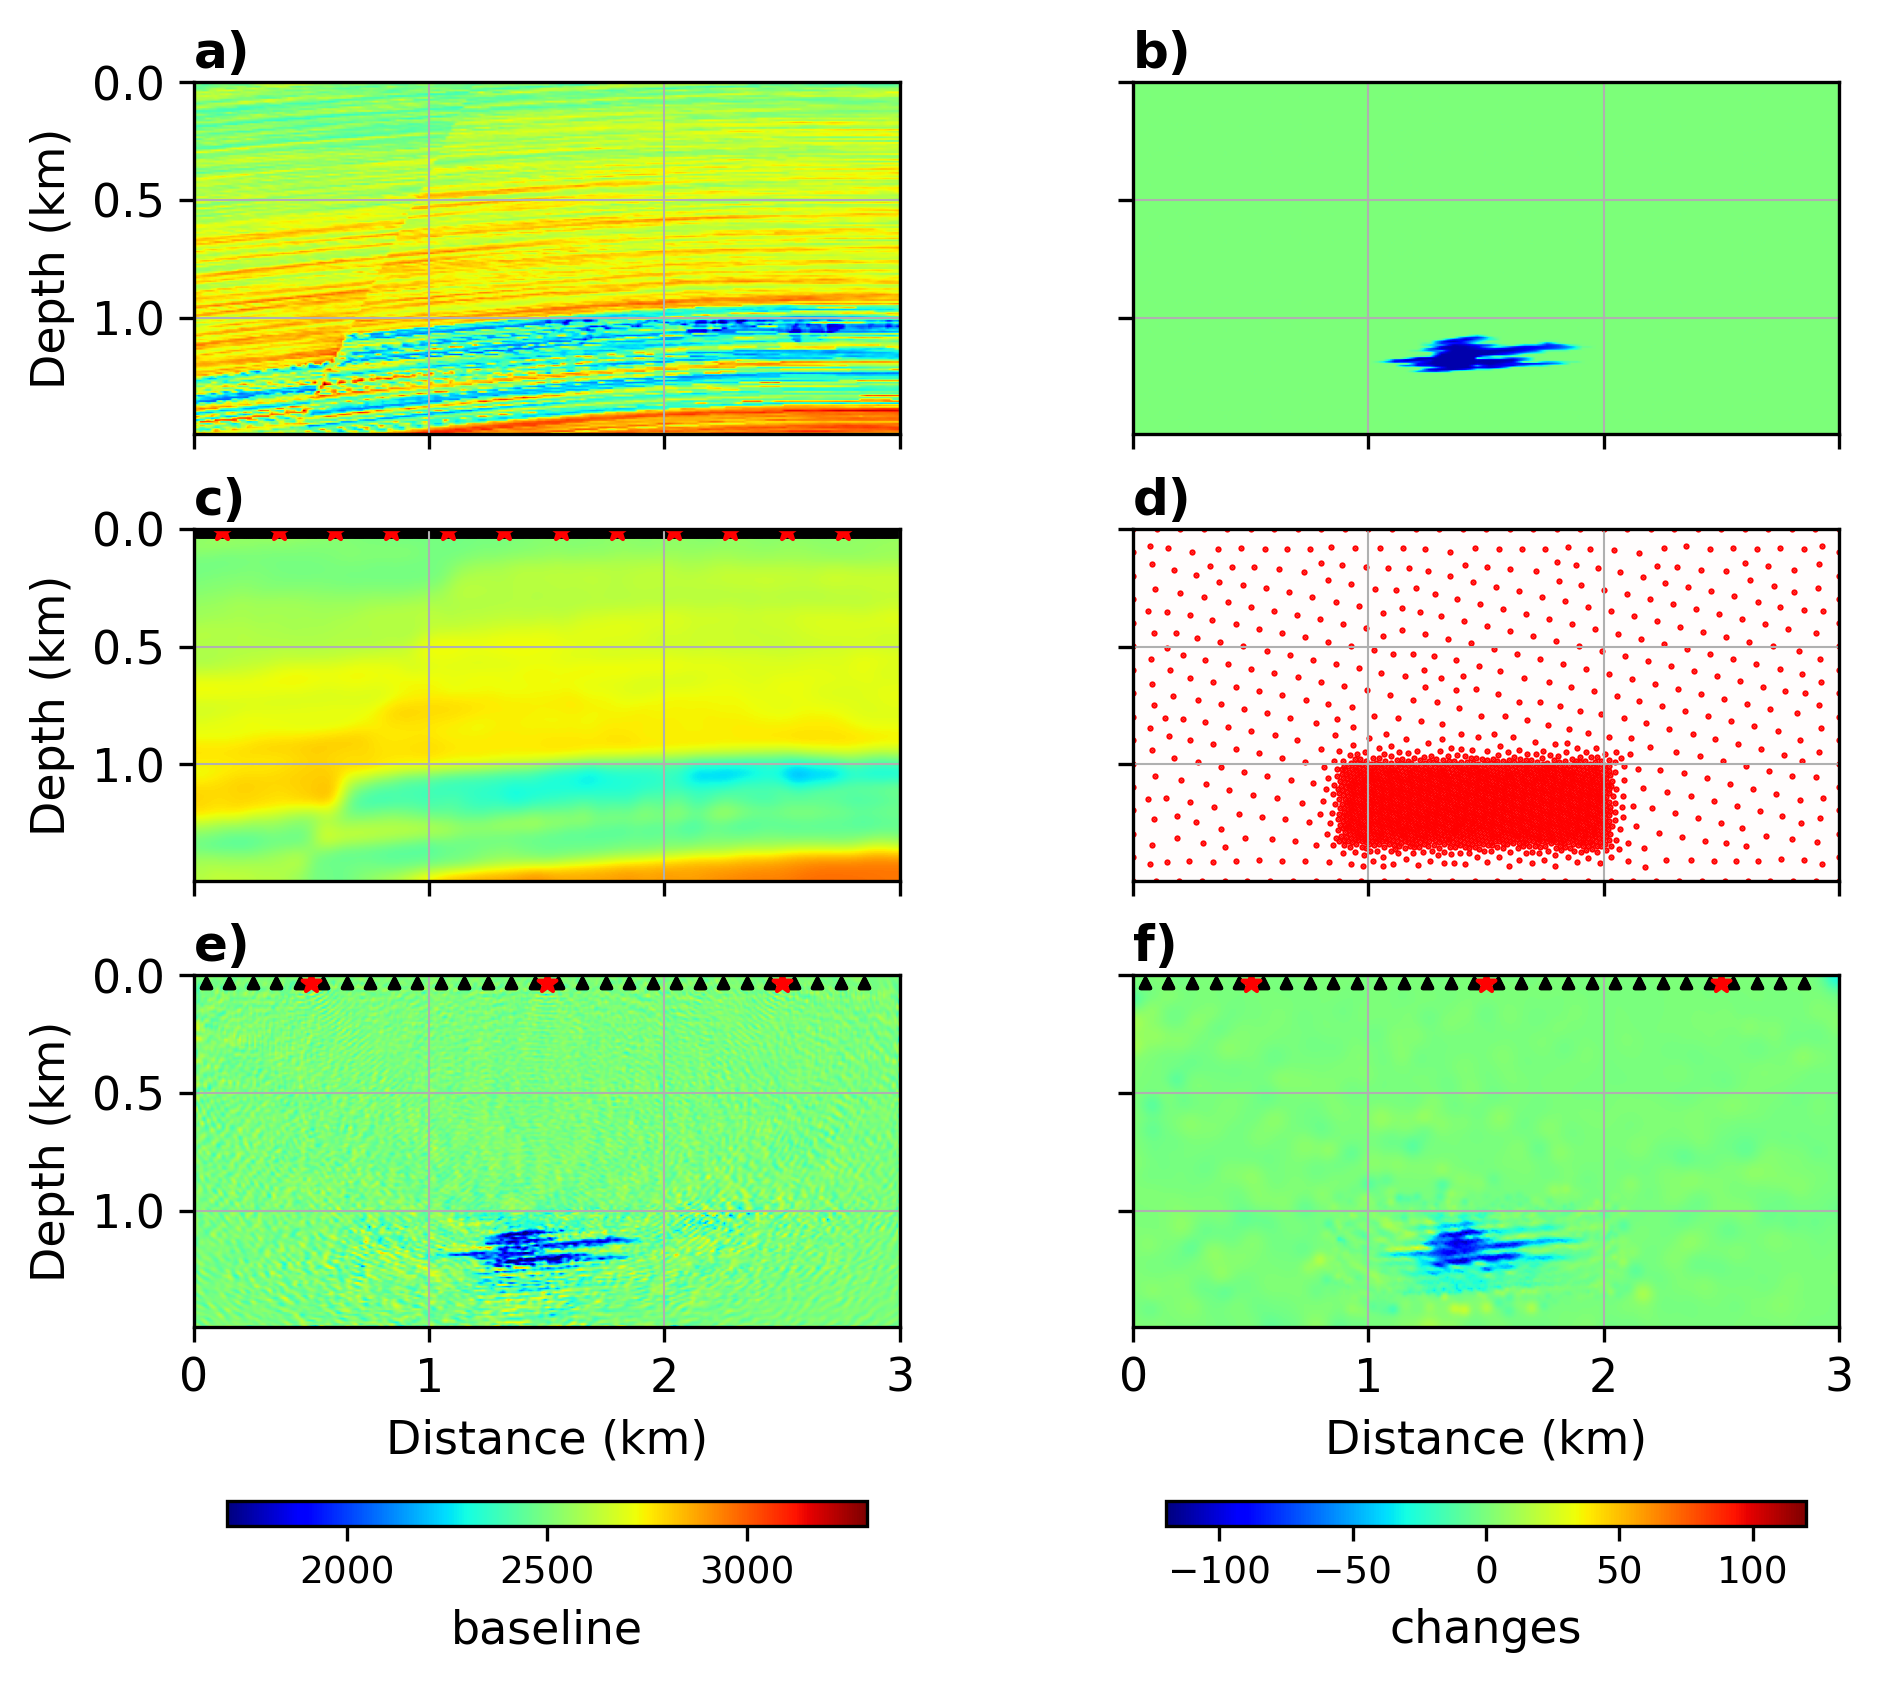

In [73]:
fontsize = 11
plt.rcParams.update({
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,
        "figure.titlesize": fontsize,
})

fig, axs = plt.subplots(3, 2, figsize=(6.5, 5.5), dpi=300, constrained_layout=True)
vp_bl = model_bl.get_model('vp')
vp_ml = model_ml.get_model('vp')
vp_init = vp_init
vp_fwi_bl = model_init.get_model('vp')
vp_fwi_fd = model_init_fd.get_model('vp')
vp_fwi_rbf = model_init_rbf.get_model('vp')

aspect = 1
extent = [x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000]
cmap_range = [(1700, 3300),(-120, 120),(1700, 3300),(-1, 1),(-120, 120), (-120, 120),  (-120, 120)]
labels = ['a)', 'b)', 'c)',  'd)', 'e)', 'f)']
cmaps = ['jet','jet', 'jet', 'seismic', 'jet', 'jet']

ims = []
for k, model in enumerate([vp_bl, vp_ml - vp_bl, vp_init, vp_init*0, vp_fwi_fd-vp_fwi_bl,  vp_fwi_rbf - vp_fwi_bl]):
    i, j = np.divmod(k, 2)
    im = axs[i][j].imshow(model, extent=extent, cmap=cmaps[k], vmin=cmap_range[k][0], vmax=cmap_range[k][1], aspect=aspect)
    axs[i][j].grid(alpha=1, linewidth=0.5)
    if k==3:
        im = axs[i][j].scatter(centers_2d[:,0]/1000, centers_2d[:,1]/1000,  marker='.', color = 'r', s=1)
        axs[i][j].set_xlim([x[0]/1000, x[-1]/1000])
        axs[i][j].set_ylim([z[0]/1000, z[-1]/1000])
        axs[i][j].invert_yaxis()
        
    ims.append(im)

    if i == 2:
        axs[i][j].set_xlabel("Distance (km)")
    else:
        axs[i][j].set_xticklabels([])
    if  j == 0:
        axs[i][j].set_ylabel("Depth (km)")
    else:
        axs[i][j].set_yticklabels([])

    # plot the survey
    if k ==2:
        src = survey.source.get_loc(type='pr')
        rec_vx = survey.receiver.get_loc(type='vx')
        rec_vz = survey.receiver.get_loc(type='vz')
        axs[i][j].scatter(rec_vx[:, 0]/1000, rec_vx[:, 1]/1000, label='GEO-X', marker='^', s=5, c='k', )
        axs[i][j].scatter(rec_vz[:, 0]/1000, rec_vz[:, 1]/1000, label='GEO-Z', marker='^', s=5, c='k', )
        axs[i][j].scatter(src[:, 0]/1000, src[:, 1]/1000,   label='Source', marker='*', s=20, c='r')
    if k > 3:
        src = survey_monitor.source.get_loc(type='pr')
        rec_vx = survey_monitor.receiver.get_loc(type='vx')
        rec_vz = survey_monitor.receiver.get_loc(type='vz')
        axs[i][j].scatter(rec_vx[:, 0]/1000, rec_vx[:, 1]/1000, label='GEO-X', marker='^', s=5, c='k', )
        axs[i][j].scatter(rec_vz[:, 0]/1000, rec_vz[:, 1]/1000, label='GEO-Z', marker='^', s=5, c='k', )
        axs[i][j].scatter(src[:, 0]/1000, src[:, 1]/1000,   label='Source', marker='*', s=20, c='r')
    
    axs[i][j].text(-0.0, 1.15, labels[k], transform=axs[i][j].transAxes, fontsize=12, va='top', fontweight='bold')

    if k == 4:
        cbar = fig.colorbar(ims[0], ax=axs[i, j], location='bottom', pad=0.1, shrink=0.7, aspect=25, label = 'baseline')
        cbar.ax.tick_params(labelsize=9)
    if k == 5:
        cbar = fig.colorbar(ims[k], ax=axs[i, j], location='bottom', pad=0.1, shrink=0.7, aspect=25, label = 'changes')
        cbar.ax.tick_params(labelsize=9)

plt.savefig('FWI-CO2.png', dpi=300, bbox_inches='tight')
plt.show()